In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
with open('trainset_python/python/class_names.txt') as f:
    classes = f.readlines()

for i,c in enumerate(classes):
    classes[i] = c.strip()
    
classes

['0: other',
 '1: comcuc',
 '2: cowpig1',
 '3: eucdov',
 '4: eueowl1',
 '5: grswoo',
 '6: tawowl1']

In [3]:
with open('trainset_python/python/feature_names.txt') as f:
    features = f.readlines()

for i,feature in enumerate(features):
    features[i] = feature.strip()
    
len(features)

548

In [4]:
#all files in one dataframe
idx = pd.Series([i for i in range(100)])

rootdir = os. getcwd()
files = pd.DataFrame([])
files_stand = pd.DataFrame([])
lables = pd.DataFrame([])
data = pd.DataFrame([])
data_stand = pd.DataFrame([])
    
for i,f in enumerate(glob.glob(rootdir + '/**/*.npy', recursive=True)):
    if (i % 2) == 0:
        lable = pd.DataFrame(np.load(f))
        #lable = lable.rename(columns={lable.columns[0]: "overall_class"})
        for i, col in enumerate(lable.columns):
            if i == 0:
                lable = lable.rename(columns={lable.columns[0]: "overall_class_vote"})
            else:
                lable = lable.rename(columns={col: "class_vote_" + str(i)})
        if lables.empty:
            lables = lable
        else:
            idx = idx + (i*100)
            lable.index = idx
            lables = lables.append(lable)
    else:
        file = pd.DataFrame(np.load(f), columns = features)
        file_stand = pd.DataFrame(StandardScaler().fit_transform(np.load(f)), columns = features)
        if files.empty:
            files = file
        else:
            idx = idx + (i*100)
            file.index = idx
            files = files.append(file)
        if files_stand.empty:
            files_stand = file_stand
        else:
            idx = idx + (i*100)
            file_stand.index = idx
            files_stand = files_stand.append(file_stand)


lables.index = pd.Series([i for i in range(len(lables))])
files.index = pd.Series([i for i in range(len(lables))])
files_stand.index = pd.Series([i for i in range(len(lables))])

In [5]:
lables.loc[81101]

overall_class_vote    5.0
class_vote_1          5.0
class_vote_2          5.0
class_vote_3          5.0
class_vote_4          NaN
class_vote_5          NaN
class_vote_6          NaN
class_vote_7          NaN
Name: 81101, dtype: float64

In [6]:
file_stand_incl_labels = pd.concat([files_stand, lables], axis=1, join='inner')



In [7]:
file_stand_incl_labels.loc[0, ['class_vote_1', 'class_vote_2', 'class_vote_3',
                              'class_vote_4', 'class_vote_5', 'class_vote_6', 'class_vote_7']]

class_vote_1    0.0
class_vote_2    0.0
class_vote_3    0.0
class_vote_4    1.0
class_vote_5    0.0
class_vote_6    0.0
class_vote_7    NaN
Name: 0, dtype: float64

In [8]:
import math


def sample_dataframe_by_threshold(hyper_param_threshold_idx):
    thresholds = np.array([1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 7/7])
    dropped_indices = []
    nr_annotators = [0, 0, 0, 0, 0]

    print(f'Total samples: {len(file_stand_incl_labels)}')
    for n, threshold in enumerate(thresholds):
        invalid_samples = 0
        inner_list_dropped_indices = []
        for i, sample in enumerate(file_stand_incl_labels.copy().to_numpy()[:, -7:]):
            sample_has_nans = 0
            sample_nan_idx = []
            for l, val in enumerate(sample):
                if math.isnan(val):
                    sample_nan_idx.append(l)
                    sample_has_nans += 1
            # remove nans from sample
            sample = np.delete(sample, sample_nan_idx)
            # print(sample)
            classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                            np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
            # accept fragments with no votes and votes above current threshold
            if np.max(classes_vote) / len(sample) > 0:
                """if len(sample) == 3 and np.max(classes_vote) / len(sample) < 3/3:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[0] += 1"""
                if len(sample) == 4 and np.max(classes_vote) / len(sample) < 3/4:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[1] += 1
                elif len(sample) == 5 and np.max(classes_vote) / len(sample) < 3/5:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[2] += 1
                elif len(sample) == 6 and np.max(classes_vote) / len(sample) < 4/6:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[3] += 1
                elif len(sample) == 7 and np.max(classes_vote) / len(sample) < 5/7:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[4] += 1
                    
        dropped_indices.append(inner_list_dropped_indices)
        print(
            f'Samples where annotators agree >= {threshold*100}%: {len(file_stand_incl_labels) - invalid_samples} (dropped samples: {invalid_samples})')
    
    # drop the samples with < threshold than selected    
    sampled_dataframe = file_stand_incl_labels.drop(dropped_indices[hyper_param_threshold_idx]).reset_index()
    # drop vote columns and index_column
    sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    print(nr_annotators)
    return sampled_dataframe


In [20]:
sampled_dataframe = sample_dataframe_by_threshold(hyper_param_threshold_idx=4)

Total samples: 120000
Samples where annotators agree >= 14.285714285714285%: 111007 (dropped samples: 8993)
Samples where annotators agree >= 28.57142857142857%: 106373 (dropped samples: 13627)
Samples where annotators agree >= 42.857142857142854%: 103834 (dropped samples: 16166)
Samples where annotators agree >= 57.14285714285714%: 101648 (dropped samples: 18352)
Samples where annotators agree >= 71.42857142857143%: 99532 (dropped samples: 20468)
Samples where annotators agree >= 85.71428571428571%: 96779 (dropped samples: 23221)
Samples where annotators agree >= 100.0%: 92805 (dropped samples: 27195)
[1512, 0, 10899, 50540, 65071]


In [11]:
sampled_dataframe

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99527,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
99528,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
99529,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
99530,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931


In [11]:
import math


def sample_dataframe_by_single_threshold(hyper_param_threshold_idx):
    dropped_indices = []

    print(f'Total samples: {len(file_stand_incl_labels)}')
    invalid_samples = 0
    for i, sample in enumerate(file_stand_incl_labels.copy().to_numpy()[:, -7:]):
        sample_has_nans = 0
        sample_nan_idx = []
        for l, val in enumerate(sample):
            if math.isnan(val):
                sample_nan_idx.append(l)
                sample_has_nans += 1
        # remove nans from sample
        sample = np.delete(sample, sample_nan_idx)
        # print(sample)
        classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                        np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
        # accept fragments with no votes and votes above current threshold
        if np.max(classes_vote) / len(sample) > 0:
            if np.max(classes_vote) / len(sample) < hyper_param_threshold_idx:
                invalid_samples += 1
                dropped_indices.append(i)

    print(f'Samples where annotators agree >= {hyper_param_threshold_idx*100}%: {len(file_stand_incl_labels) - invalid_samples} (dropped samples: {invalid_samples})')

    # drop the samples with < threshold than selected
    sampled_dataframe = file_stand_incl_labels.drop(dropped_indices).reset_index()
    # drop vote columns and index_column
    sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    return sampled_dataframe


In [12]:
sampled_dataframe = sample_dataframe_by_single_threshold(hyper_param_threshold_idx=5/7)

Total samples: 120000
Samples where annotators agree >= 71.42857142857143%: 96656 (dropped samples: 23344)


In [67]:
sampled_dataframe

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96651,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
96652,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
96653,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
96654,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931


In [9]:
_annotations = [
    [2/3, 3/4, 4/5, 4/6, 4/7], # majority voteing
    [2/3, 3/4, 4/5, 4/6, 5/7], # out voteing
    [2/3, 3/4, 4/5, 5/6, 5/7], # higher majority
    [2/3, 3/4, 4/5, 5/6, 6/7], # at most one wrong
]

In [38]:
import math


def sample_dataframe_by_thresholds(hyper_param_thresholds):
    dropped_indices = []
    nr_annotators = [0, 0, 0, 0, 0]
    _return_val = []
    #print(f'Total samples: {len(file_stand_incl_labels)}')
    for n, threshold in enumerate(hyper_param_thresholds):
        invalid_samples = 0
        inner_list_dropped_indices = []
        dropped_indices = []
        
        for i, sample in enumerate(file_stand_incl_labels.copy().to_numpy()[:, -7:]):
            sample_has_nans = 0
            sample_nan_idx = []
            for l, val in enumerate(sample):
                if math.isnan(val):
                    sample_nan_idx.append(l)
                    sample_has_nans += 1
            # remove nans from sample
            sample = np.delete(sample, sample_nan_idx)
            # print(sample)
            classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                            np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
            # accept fragments with no votes and votes above current threshold
            if np.max(classes_vote) / len(sample) > 0:
                if len(sample) == 3 and np.max(classes_vote) / len(sample) < threshold:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[0] += 1
                elif len(sample) == 4 and np.max(classes_vote) / len(sample) < threshold:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[1] += 1
                elif len(sample) == 5 and np.max(classes_vote) / len(sample) < threshold:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[2] += 1
                elif len(sample) == 6 and np.max(classes_vote) / len(sample) < threshold:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[3] += 1
                elif len(sample) == 7 and np.max(classes_vote) / len(sample) < threshold:
                    invalid_samples += 1
                    inner_list_dropped_indices.append(i)
                    nr_annotators[4] += 1
        dropped_indices.append(inner_list_dropped_indices)
        print(f'Samples where annotators agree >= {threshold*100}%: {len(file_stand_incl_labels) - invalid_samples} (dropped samples: {invalid_samples})')
        _return_val.append(len(file_stand_incl_labels) - invalid_samples)
        #print(len(file_stand_incl_labels) - invalid_samples)
    return hyper_param_thresholds, _return_val
    # drop the samples with < threshold than selected    
    #sampled_dataframe = file_stand_incl_labels.drop(dropped_indices[hyper_param_threshold_idx]).reset_index()
    # drop vote columns and index_column
    #sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    #print(nr_annotators)
    #return sampled_dataframe


In [39]:
sample_dataframe_by_thresholds(hyper_param_thresholds=[2/3, 3/4, 4/5, 4/6, 5/7])

Samples where annotators agree >= 66.66666666666666%: 99013 (dropped samples: 20987)
Samples where annotators agree >= 75.0%: 93903 (dropped samples: 26097)
Samples where annotators agree >= 80.0%: 93903 (dropped samples: 26097)
Samples where annotators agree >= 66.66666666666666%: 99013 (dropped samples: 20987)
Samples where annotators agree >= 71.42857142857143%: 96656 (dropped samples: 23344)


([0.6666666666666666, 0.75, 0.8, 0.6666666666666666, 0.7142857142857143],
 [99013, 93903, 93903, 99013, 96656])


[0.6666666666666666, 0.75, 0.8, 0.6666666666666666, 0.5714285714285714]
Samples where annotators agree >= 66.66666666666666%: 99013 (dropped samples: 20987)
Samples where annotators agree >= 75.0%: 93903 (dropped samples: 26097)
Samples where annotators agree >= 80.0%: 93903 (dropped samples: 26097)
Samples where annotators agree >= 66.66666666666666%: 99013 (dropped samples: 20987)
Samples where annotators agree >= 57.14285714285714%: 101648 (dropped samples: 18352)

[0.6666666666666666, 0.75, 0.8, 0.6666666666666666, 0.7142857142857143]
Samples where annotators agree >= 66.66666666666666%: 99013 (dropped samples: 20987)
Samples where annotators agree >= 75.0%: 93903 (dropped samples: 26097)
Samples where annotators agree >= 80.0%: 93903 (dropped samples: 26097)
Samples where annotators agree >= 66.66666666666666%: 99013 (dropped samples: 20987)
Samples where annotators agree >= 71.42857142857143%: 96656 (dropped samples: 23344)

[0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.

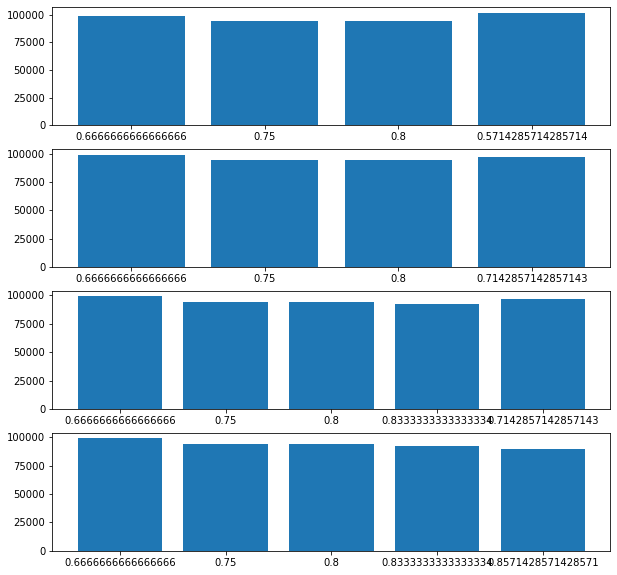

In [37]:
_annotations = [
    [2/3, 3/4, 4/5, 4/6, 4/7], # majority voteing
    [2/3, 3/4, 4/5, 4/6, 5/7], # out voteing
    [2/3, 3/4, 4/5, 5/6, 5/7], # higher majority
    [2/3, 3/4, 4/5, 5/6, 6/7], # at most one wrong
]

fig, axis = plt.subplots(4, figsize=(10, 10))
for i, thr in enumerate(_annotations):
    print()
    print(thr)
    _, y = sample_dataframe_by_thresholds(hyper_param_thresholds=thr)
    #y = [99013, 93903, 93903, 99013, 101648]
    #x = [str(2/3), str(3/4), str(4/5), str(4/6), str(4/7)]
    x = [str(_x) for _x in thr]

    axis[i].bar(x, y)
plt.show()


In [46]:
import math


def sample_dataframe_by_threshold():
    dropped_indices = []
    nr_annotators = [0, 0, 0, 0, 0]

    invalid_samples = 0
    for i, sample in enumerate(file_stand_incl_labels.copy().to_numpy()[:, -7:]):
        sample_has_nans = 0
        sample_nan_idx = []
        for l, val in enumerate(sample):
            if math.isnan(val):
                sample_nan_idx.append(l)
                sample_has_nans += 1
        # remove nans from sample
        sample = np.delete(sample, sample_nan_idx)
        # print(sample)
        classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                        np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
        # accept fragments with no votes and votes above current threshold
        if np.max(classes_vote) / len(sample) > 0:
            #accept all samples for 3 annotators
            """if len(sample) == 3 and np.max(classes_vote) / len(sample) < 3/3:
                invalid_samples += 1
                inner_list_dropped_indices.append(i)
                nr_annotators[0] += 1"""
            if len(sample) == 4 and np.max(classes_vote) / len(sample) < 3/4:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[1] += 1
            elif len(sample) == 5 and np.max(classes_vote) / len(sample) < 3/5:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[2] += 1
            elif len(sample) == 6 and np.max(classes_vote) / len(sample) < 4/6:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[3] += 1
            elif len(sample) == 7 and np.max(classes_vote) / len(sample) < 5/7:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[4] += 1
    # drop the samples with < threshold than selected
    sampled_dataframe = file_stand_incl_labels.drop(dropped_indices).reset_index()
    # drop vote columns and index_column
    sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    #print(nr_annotators)
    return sampled_dataframe


In [47]:
sampled_dataframe = sample_dataframe_by_threshold()

[0, 0, 1557, 7220, 11475]


In [48]:
sampled_dataframe

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99743,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
99744,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
99745,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
99746,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931
